<a href="https://colab.research.google.com/github/aman4680/cs725-FML/blob/main/FML_project_Extended.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference : https://github.com/d0r1h/CO2-Emission-by-Cars/blob/main/notebook/co2-emission-by-cars.ipynb

**Download Dataset from Kaggle**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/FML

'CO2 Emissions_Canada.csv'  'Data Description.csv'   kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/FML/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kaggle

dataset_path = "debajyotipodder/co2-emission-by-vehicles"

download_directory = "/content/drive/MyDrive/FML"

kaggle.api.dataset_download_files(dataset_path, path=download_directory, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles


**Import Neccesary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**Read Data**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/FML/CO2 Emissions_Canada.csv')
data.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [ ]:
print(data.shape)
print("\n")
data.info()

(7385, 12)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64 

**Data Preprocessing**

Rename Columns : For code readability and better usage

In [ ]:
data = data.rename(columns={
    'Vehicle Class': 'Vehicle_Class',
    'Engine Size(L)': 'Engine_Size',
    'Fuel Type': 'Fuel_Type',
    'Fuel Consumption City (L/100 km)': 'Fuel_Consumption_City',
    'Fuel Consumption Hwy (L/100 km)': 'Fuel_Consumption_Hwy',
    'Fuel Consumption Comb (L/100 km)': 'Fuel_Consumption_Comb',
    'Fuel Consumption Comb (mpg)': 'Fuel_Consumption_Comb1',
    'CO2 Emissions(g/km)': 'CO2_Emissions'
})

In [ ]:
missing_values = data.isnull().sum()
print(missing_values)

Make                      0
Model                     0
Vehicle_Class             0
Engine_Size               0
Cylinders                 0
Transmission              0
Fuel_Type                 0
Fuel_Consumption_City     0
Fuel_Consumption_Hwy      0
Fuel_Consumption_Comb     0
Fuel_Consumption_Comb1    0
CO2_Emissions             0
dtype: int64


Remove Duplicates

In [ ]:
duplicated_rows = data.duplicated().sum()
print(duplicated_rows)

1103


In [ ]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True, drop=True)
print(data.shape)

(6282, 12)


Remove Outliers

In [ ]:
numerical_features=data.select_dtypes(include=np.number)
Q1 = numerical_features.quantile(0.25)
Q3 = numerical_features.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Engine_Size                1.7
Cylinders                  2.0
Fuel_Consumption_City      4.6
Fuel_Consumption_Hwy       2.8
Fuel_Consumption_Comb      3.8
Fuel_Consumption_Comb1    10.0
CO2_Emissions             81.0
dtype: float64


In [ ]:
outlier = pd.DataFrame((numerical_features < (Q1 - 1.5 * IQR)) | (numerical_features > (Q3 + 1.5 * IQR)))

for i in outlier.columns:
    print('Total number of Outliers in column {} are {}'.format(i, (len(outlier[outlier[i] == True][i]))))

Total number of Outliers in column Engine_Size are 121
Total number of Outliers in column Cylinders are 177
Total number of Outliers in column Fuel_Consumption_City are 116
Total number of Outliers in column Fuel_Consumption_Hwy are 150
Total number of Outliers in column Fuel_Consumption_Comb are 115
Total number of Outliers in column Fuel_Consumption_Comb1 are 95
Total number of Outliers in column CO2_Emissions are 74


### Since outliers are present therefore either we will use MAE, Huber Loss, or Quantile Loss to remove outliers

In [ ]:
data = data[~((numerical_features < (Q1 - 1.5 * IQR)) |(numerical_features > (Q3 + 1.5 * IQR))).any(axis=1)]
data.reset_index(inplace=True, drop=True)
numerical_features = data.select_dtypes(include=np.number)

In [ ]:
print(data.shape)
data.head()

(5816, 12)


,Make,Model,Vehicle_Class,Engine_Size,Cylinders,Transmission,Fuel_Type,Fuel_Consumption_City,Fuel_Consumption_Hwy,Fuel_Consumption_Comb,Fuel_Consumption_Comb1,CO2_Emissions
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
3,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
4,ACURA,RLX,MID-SIZE,3.5,6,AS6,Z,11.9,7.7,10.0,28,230


Feature Engineering (Part of Pre-processing)

In [ ]:
data['Make'].unique()

array(['ACURA', 'ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'BENTLEY', 'BMW',
       'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE', 'FIAT',
       'FORD', 'GMC', 'HONDA', 'HYUNDAI', 'INFINITI', 'JAGUAR', 'JEEP',
       'KIA', 'LAND ROVER', 'LEXUS', 'LINCOLN', 'MASERATI', 'MAZDA',
       'MERCEDES-BENZ', 'MINI', 'MITSUBISHI', 'NISSAN', 'PORSCHE', 'RAM',
       'SCION', 'SMART', 'SUBARU', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'GENESIS', 'LAMBORGHINI'], dtype=object)

In [ ]:
data['Make_Type'] = data['Make'].replace(['ALFA ROMEO', 'ASTON MARTIN', 'LAMBORGHINI', 'PORSCHE', 'MASERATI'], 'Sports')
data['Make_Type'] = data['Make_Type'].replace(['AUDI', 'BMW', 'LEXUS', 'INFINITI', 'VOLVO', 'MINI', 'MERCEDES-BENZ', 'GENESIS', 'JAGUAR'],'Premium')
data['Make_Type'] = data['Make_Type'].replace(['BENTLEY', 'ROLLS-ROYCE', 'LAMBORGHINI', 'ASTON MARTIN','MASERATI', 'LAND ROVER', 'CADILLAC','LINCOLN'], 'Luxury')
data['Make_Type'] = data['Make_Type'].replace(['ACURA', 'BUICK', 'CHEVROLET', 'FORD', 'GMC', 'HONDA', 'HYUNDAI', 'KIA', 'MAZDA', 'NISSAN', 'SUBARU', 'TOYOTA', 'VOLKSWAGEN', 'DODGE', 'JEEP', 'RAM', 'CHRYSLER', 'FIAT', 'SCION', 'SMART', 'MITSUBISHI'],'General')

data.drop(['Make'], inplace=True, axis=1)

data['Make_Type'].unique()

data['Make_Type'].value_counts()


,count
Make_Type,
General,3408
Premium,1729
Sports,386
Luxury,293


In [ ]:
data['Vehicle_Class_Type'] = data['Vehicle_Class'].replace(['COMPACT', 'MINICOMPACT', 'SUBCOMPACT'], 'Hatchback')
data['Vehicle_Class_Type'] = data['Vehicle_Class_Type'].replace(['MID-SIZE', 'TWO-SEATER', 'FULL-SIZE', 'STATION WAGON - SMALL', 'STATION WAGON - MID-SIZE'],'Sedan')
data['Vehicle_Class_Type'] = data['Vehicle_Class_Type'].replace(['SUV - SMALL', 'SUV - STANDARD', 'MINIVAN'],  'SUV')
data['Vehicle_Class_Type'] = data['Vehicle_Class_Type'].replace(['VAN - CARGO', 'VAN - PASSENGER', 'PICKUP TRUCK - STANDARD', 'SPECIAL PURPOSE VEHICLE', 'PICKUP TRUCK - SMALL'], 'Truck')


data.drop(['Vehicle_Class'], inplace=True,  axis=1)

data['Vehicle_Class_Type'].unique()


array(['Hatchback', 'SUV', 'Sedan', 'Truck'], dtype=object)

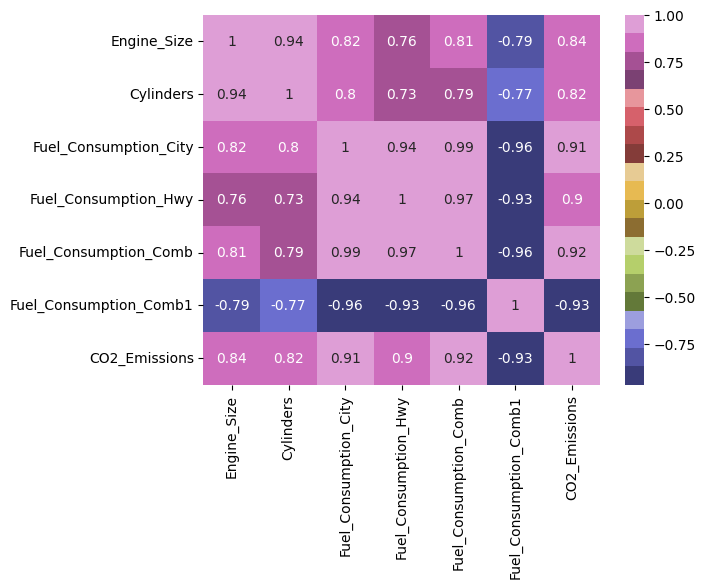

In [ ]:
corr =  numerical_features.corr()

corr =numerical_features.corr(method='pearson')
sns.heatmap(corr, annot=True,cmap='tab20b')
plt.show()

Remove Skewness : There are many problem happens to model with it in data like outliers, fitting problem etc.

In [ ]:
numerical_features.skew()
log_transformed_num = np.log(numerical_features)
log_transformed_num.skew()

,0
Engine_Size,0.090971
Cylinders,0.237487
Fuel_Consumption_City,0.008024
Fuel_Consumption_Hwy,0.181610
Fuel_Consumption_Comb,0.089446
Fuel_Consumption_Comb1,-0.090942
CO2_Emissions,-0.036539


In [ ]:
data.head()

,Model,Engine_Size,Cylinders,Transmission,Fuel_Type,Fuel_Consumption_City,Fuel_Consumption_Hwy,Fuel_Consumption_Comb,Fuel_Consumption_Comb1,CO2_Emissions,Make_Type,Vehicle_Class_Type
0,ILX,2.0,4,AS5,Z,9.9,6.7,8.5,33,196,General,Hatchback
1,ILX,2.4,4,M6,Z,11.2,7.7,9.6,29,221,General,Hatchback
2,MDX 4WD,3.5,6,AS6,Z,12.7,9.1,11.1,25,255,General,SUV
3,RDX AWD,3.5,6,AS6,Z,12.1,8.7,10.6,27,244,General,SUV
4,RLX,3.5,6,AS6,Z,11.9,7.7,10.0,28,230,General,Sedan


Encode Categorical features to One-hot encoding

In [ ]:
categorical_features = pd.get_dummies(data = data[["Fuel_Type","Transmission","Make_Type","Vehicle_Class_Type"]], drop_first = True)
encoded_data = pd.concat([log_transformed_num, categorical_features], axis = 1)
encoded_data.head()

,Engine_Size,Cylinders,Fuel_Consumption_City,Fuel_Consumption_Hwy,Fuel_Consumption_Comb,Fuel_Consumption_Comb1,CO2_Emissions,Fuel_Type_E,Fuel_Type_N,Fuel_Type_X,...,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Make_Type_Luxury,Make_Type_Premium,Make_Type_Sports,Vehicle_Class_Type_SUV,Vehicle_Class_Type_Sedan,Vehicle_Class_Type_Truck
0,0.693147,1.386294,2.292535,1.902108,2.140066,3.496508,5.278115,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.875469,1.386294,2.415914,2.041220,2.261763,3.367296,5.398163,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,1.252763,1.791759,2.541602,2.208274,2.406945,3.218876,5.541264,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,1.252763,1.791759,2.493205,2.163323,2.360854,3.295837,5.497168,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,1.252763,1.791759,2.476538,2.041220,2.302585,3.332205,5.438079,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
encoded_data.shape

(5816, 43)

Standardization because Not normalized data

In [ ]:
features_to_scale = log_transformed_num.drop(['CO2_Emissions'], axis=1)

In [ ]:
scalar = MinMaxScaler()
scalar.fit(features_to_scale)
scaled_data = scalar.transform(features_to_scale)
scaled_data = pd.DataFrame(scalar.fit_transform(features_to_scale), columns = ['Engine_Size','Cylinders','Fuel_Consumption_City','Fuel_Consumption_Hwy','Fuel_Consumption_Comb','Fuel_Consumption_Comb1'])
df = pd.concat([scaled_data, categorical_features], axis = 1)
df.shape

(5816, 42)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Engine_Size               5816 non-null   float64
 1   Cylinders                 5816 non-null   float64
 2   Fuel_Consumption_City     5816 non-null   float64
 3   Fuel_Consumption_Hwy      5816 non-null   float64
 4   Fuel_Consumption_Comb     5816 non-null   float64
 5   Fuel_Consumption_Comb1    5816 non-null   float64
 6   Fuel_Type_E               5816 non-null   bool   
 7   Fuel_Type_N               5816 non-null   bool   
 8   Fuel_Type_X               5816 non-null   bool   
 9   Fuel_Type_Z               5816 non-null   bool   
 10  Transmission_A4           5816 non-null   bool   
 11  Transmission_A5           5816 non-null   bool   
 12  Transmission_A6           5816 non-null   bool   
 13  Transmission_A7           5816 non-null   bool   
 14  Transmis

In [ ]:
pca = PCA(n_components=None)
principal_components = pca.fit_transform(df)

In [ ]:
principal_components

array([[ 4.32267798e-01,  1.36827653e-01,  2.55772428e-01, ...,
         7.37446647e-03, -2.76318678e-03,  3.11123606e-03],
       [ 4.75714106e-01,  1.77774556e-01,  1.78137093e-01, ...,
         2.51902394e-03, -7.65931152e-03, -2.64001567e-03],
       [ 1.95496533e-01, -6.77095275e-01,  3.41035201e-01, ...,
         5.44343583e-03, -1.36633039e-02, -1.32484683e-05],
       ...,
       [ 9.34137608e-01, -5.30690576e-01,  9.85226927e-01, ...,
         4.27269318e-04, -1.01221849e-02, -1.11733655e-03],
       [ 9.28084910e-01, -4.91752569e-01,  1.02190329e+00, ...,
         1.39320429e-03,  1.34576544e-02,  1.55261546e-03],
       [ 9.38388257e-01, -5.56508906e-01,  9.60476854e-01, ...,
         7.85273828e-04, -1.33610277e-02,  3.96331466e-03]])

In [ ]:
pca_df = pd.DataFrame(principal_components)
pca_df

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.432268,0.136828,0.255772,-0.504971,0.247023,-0.248643,-0.453857,-0.118338,0.103537,0.223217,...,-0.086302,-0.043995,-0.093942,-0.015845,-0.003376,-0.007215,0.000415,0.007374,-0.002763,0.003111
1,0.475714,0.177775,0.178137,-0.896700,0.218078,-0.416451,0.086758,0.510370,0.316402,0.081144,...,0.080514,-0.005605,-0.014062,-0.002432,-0.001927,-0.003479,-0.000469,0.002519,-0.007659,-0.002640
2,0.195497,-0.677095,0.341035,0.420370,0.746737,-0.608634,-0.043345,0.095196,0.200171,0.114209,...,0.010325,-0.010067,-0.024982,-0.007517,-0.000561,-0.007145,-0.000483,0.005443,-0.013663,-0.000013
3,0.188695,-0.632886,0.382555,0.404785,0.746655,-0.605469,-0.062924,0.080157,0.197026,0.118999,...,0.019758,-0.013677,-0.022223,-0.008294,-0.000124,-0.007765,-0.000370,0.006538,0.009114,0.002615
4,0.474190,0.472909,-0.404902,0.560165,0.671812,-0.474769,-0.051581,-0.019111,0.271138,0.087871,...,0.026737,-0.014446,-0.040303,-0.007342,-0.000827,-0.005749,-0.001371,0.004472,-0.006458,-0.000395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5811,0.922242,-0.450838,1.059551,0.250180,-0.306877,0.250933,-0.226821,0.114422,0.116597,0.108979,...,0.033153,-0.007678,-0.040439,0.000074,0.001383,0.000130,0.001545,0.001969,-0.003112,0.003634
5812,0.928085,-0.491753,1.021903,0.264136,-0.306565,0.248069,-0.209236,0.127832,0.119152,0.105140,...,0.021373,-0.002221,-0.017890,-0.001070,0.000955,0.000093,0.000949,0.001393,0.013458,0.001553
5813,0.934138,-0.530691,0.985227,0.277929,-0.306525,0.245272,-0.191920,0.141148,0.121973,0.100840,...,0.013490,0.000666,-0.023787,-0.000142,0.000592,0.000705,0.000891,0.000427,-0.010122,-0.001117
5814,0.928085,-0.491753,1.021903,0.264136,-0.306565,0.248069,-0.209236,0.127832,0.119152,0.105140,...,0.021373,-0.002221,-0.017890,-0.001070,0.000955,0.000093,0.000949,0.001393,0.013458,0.001553


In [ ]:
print("PCA Components (loadings):")
print(pca.components_)

PCA Components (loadings):
[[ 4.30240969e-02  9.06849712e-02  4.07907844e-02 ... -1.60864207e-01
   1.30749609e-01 -1.04215317e-01]
 [-2.08582049e-01 -2.64573973e-01 -2.03211456e-01 ... -4.86910045e-01
   5.71209124e-01 -1.38920989e-01]
 [-2.58119469e-01 -3.41155283e-01 -2.07931673e-01 ...  4.69073710e-01
  -3.61026468e-01 -3.41313125e-01]
 ...
 [ 5.13667785e-03  1.35392892e-03  3.01916154e-02 ...  3.85771337e-03
  -3.97537519e-04  6.52122030e-03]
 [-1.42096138e-03 -2.15638220e-03  4.23677348e-01 ... -4.03628243e-04
   1.11120464e-04 -1.62624262e-03]
 [-1.19316243e-03 -3.67402911e-04 -5.37790768e-01 ...  4.26723921e-04
  -1.69781275e-04  7.46657339e-04]]


In [ ]:
print("Explained Variance:")
print(pca.explained_variance_)

Explained Variance:
[6.53734896e-01 3.31425472e-01 2.38483420e-01 1.73798120e-01
 1.57620234e-01 1.47669359e-01 1.09393781e-01 9.81703758e-02
 8.36940071e-02 6.34959055e-02 5.19320798e-02 4.83304770e-02
 4.20068315e-02 4.14948765e-02 3.90467998e-02 3.04421027e-02
 2.74152621e-02 2.35010874e-02 2.28310556e-02 1.77293237e-02
 1.70004874e-02 1.47536418e-02 1.34394438e-02 1.22195483e-02
 1.08338460e-02 9.98720211e-03 7.76277271e-03 6.59817932e-03
 6.11099988e-03 5.78731497e-03 5.16239811e-03 4.46707049e-03
 3.03863950e-03 1.59427295e-03 1.09294153e-03 7.12216773e-04
 3.69919162e-04 2.04074002e-04 1.69878389e-04 1.41498918e-04
 7.52244719e-05 8.49897935e-06]


In [ ]:
pca_df.shape

(5816, 42)

In [ ]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative Explained Variance Ratio:")
print(cumulative_explained_variance)

Cumulative Explained Variance Ratio:
[0.2590336  0.39035646 0.48485228 0.55371744 0.61617232 0.6746843
 0.71803011 0.75692879 0.79009141 0.8152508  0.83582818 0.85497848
 0.87162312 0.8880649  0.90353667 0.91559894 0.92646187 0.93577385
 0.94482035 0.95184536 0.95858157 0.9644275  0.9697527  0.97459453
 0.97888729 0.98284459 0.98592048 0.98853492 0.99095632 0.99324946
 0.995295   0.99706501 0.99826903 0.99890074 0.9993338  0.99961601
 0.99976259 0.99984345 0.99991076 0.99996683 0.99999663 1.        ]


In [ ]:
count  = 0
for i in range(len(cumulative_explained_variance)):
    if(cumulative_explained_variance[i] > 0.95):
        count = count + 1
        break
    count = count + 1

In [ ]:
X = pca_df.iloc[:, :count+1]
y = log_transformed_num['CO2_Emissions']

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.432268,0.136828,0.255772,-0.504971,0.247023,-0.248643,-0.453857,-0.118338,0.103537,0.223217,...,-0.032603,-0.050081,-0.092954,-0.113424,0.077206,0.174448,0.098187,-0.303510,-0.039073,-0.095876
1,0.475714,0.177775,0.178137,-0.896700,0.218078,-0.416451,0.086758,0.510370,0.316402,0.081144,...,0.012616,-0.009451,-0.044982,-0.055329,0.049788,0.096904,-0.007712,-0.265298,0.067491,-0.069185
2,0.195497,-0.677095,0.341035,0.420370,0.746737,-0.608634,-0.043345,0.095196,0.200171,0.114209,...,0.163774,0.113633,-0.145635,0.099559,0.094065,0.269516,0.034362,-0.289232,0.090765,0.121916
3,0.188695,-0.632886,0.382555,0.404785,0.746655,-0.605469,-0.062924,0.080157,0.197026,0.118999,...,0.175586,0.115008,-0.151047,0.096582,0.102431,0.261009,0.048676,-0.297440,0.097709,0.166674
4,0.474190,0.472909,-0.404902,0.560165,0.671812,-0.474769,-0.051581,-0.019111,0.271138,0.087871,...,0.132636,0.123807,-0.163554,-0.024707,0.104166,0.248444,0.045078,-0.292626,0.106144,0.123985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5811,0.922242,-0.450838,1.059551,0.250180,-0.306877,0.250933,-0.226821,0.114422,0.116597,0.108979,...,0.136954,0.111144,-0.008031,0.252971,-0.064347,0.035537,-0.003305,0.018306,0.003509,-0.015504
5812,0.928085,-0.491753,1.021903,0.264136,-0.306565,0.248069,-0.209236,0.127832,0.119152,0.105140,...,0.125911,0.110259,-0.003108,0.258042,-0.072099,0.043774,-0.016972,0.026168,-0.004022,-0.056128
5813,0.934138,-0.530691,0.985227,0.277929,-0.306525,0.245272,-0.191920,0.141148,0.121973,0.100840,...,0.115522,0.108994,0.001669,0.260343,-0.079469,0.051211,-0.029522,0.033363,-0.009983,-0.095657
5814,0.928085,-0.491753,1.021903,0.264136,-0.306565,0.248069,-0.209236,0.127832,0.119152,0.105140,...,0.125911,0.110259,-0.003108,0.258042,-0.072099,0.043774,-0.016972,0.026168,-0.004022,-0.056128


In [ ]:
y

,CO2_Emissions
0,5.278115
1,5.398163
2,5.541264
3,5.497168
4,5.438079
...,...
5811,5.389072
5812,5.446737
5813,5.480639
5814,5.446737


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4652, 21)
(1164, 21)
(4652,)
(1164,)


**Training The Models**

Linear Model

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", linear_model.score(X, y))
cv_scores = cross_val_score(linear_model, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", cv_scores)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Linear Regression): {mse}')

RMS: 0.04651630594370299
R^2 Score: 0.9475811591232014
Cross-validated R-squared scores: [0.94368227 0.94754557 0.94690294 0.93785663 0.95079492]
Mean Squared Error (Linear Regression): 0.002163766718648178


In [ ]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", lasso_model.score(X, y))
cv_scores = cross_val_score(lasso_model, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", cv_scores)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Lasso Regularization): {mse}')

RMS: 0.2023174980099017
R^2 Score: -4.767473769096142e-07
Cross-validated R-squared scores: [-1.67622783e-03 -8.15583087e-03 -6.95086642e-04 -7.65586293e-05
 -4.14203189e-03]
Mean Squared Error (Lasso Regularization): 0.04093237000098658


In [ ]:
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", ridge_model.score(X, y))
cv_scores = cross_val_score(ridge_model, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", cv_scores)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Ridge Regularization): {mse}')

RMS: 0.04651740303548954
R^2 Score: 0.9475806337073925
Cross-validated R-squared scores: [0.94368663 0.94754123 0.94689709 0.93787005 0.95079075]
Mean Squared Error (Ridge Regularization): 0.0021638687851661714


### Decision Tree

In [ ]:
dtregressor = DecisionTreeRegressor(random_state=42)
dtregressor.fit(X_train, y_train)
y_pred = dtregressor.predict(X_test)
loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", dtregressor.score(X, y))
cv_scores = cross_val_score(dtregressor, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", cv_scores)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Decision Tree): {mse}')

RMS: 0.025800444902332607
R^2 Score: 0.9964519014688983
Cross-validated R-squared scores: [0.92276732 0.98152501 0.98550043 0.96758775 0.95781467]
Mean Squared Error (Decision Tree): 0.0006656629571583006


### Bagging

In [ ]:
base_model = DecisionTreeRegressor()
bagging_model = BaggingRegressor(base_model, n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred = bagging_model.predict(X_test)
loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", bagging_model.score(X, y))
cv_scores = cross_val_score(bagging_model, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", cv_scores)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Bagging): {mse}')

RMS: 0.02100943272843666
R^2 Score: 0.995857490007001
Cross-validated R-squared scores: [0.96006117 0.9869611  0.99016026 0.97679233 0.98012901]
Mean Squared Error (Bagging): 0.0004413962635707054


### Ada Boosting

In [ ]:
boosting_model = AdaBoostRegressor(n_estimators=200, random_state=42)
boosting_model.fit(X_train, y_train)
y_pred = boosting_model.predict(X_test)
loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", boosting_model.score(X, y))
cv_scores = cross_val_score(boosting_model, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", cv_scores)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Boosting): {mse}')

RMS: 0.06745460011905854
R^2 Score: 0.894669875999493
Cross-validated R-squared scores: [0.86374678 0.8922149  0.87520051 0.89193736 0.8749018 ]
Mean Squared Error (Boosting): 0.004550123077222093


### Support Vector Regressor

In [ ]:
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)
loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", svr_model.score(X, y))
cv_scores = cross_val_score(svr_model, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", cv_scores)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (SVR): {mse}')

RMS: 0.04633536185051016
R^2 Score: 0.9492762434501155
Cross-validated R-squared scores: [0.93122393 0.94989099 0.94853175 0.94104344 0.94581857]
Mean Squared Error (SVR): 0.0021469657578177125


### Neural Network

In [ ]:
nnmodel = Sequential()
nnmodel.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
nnmodel.add(Dense(8, activation='relu'))
nnmodel.add(Dense(1))
nnmodel.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = nnmodel.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 25.0706 - mse: 25.0706 - val_loss: 11.7484 - val_mse: 11.7484
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9090 - mse: 6.9090 - val_loss: 0.5501 - val_mse: 0.5501
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3491 - mse: 0.3491 - val_loss: 0.1655 - val_mse: 0.1655
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1376 - mse: 0.1376 - val_loss: 0.1039 - val_mse: 0.1039
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0893 - mse: 0.0893 - val_loss: 0.0787 - val_mse: 0.0787
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0699 - mse: 0.0699 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0550 - mse: 0.0550 - val_loss: 0.0521 - val_mse: 0.0521
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0443 - val_mse: 0.0443
Epoch 9/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Test Loss (MSE): [0.010260970331728458, 0.010260970331728458]
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error on Test Data: 0.010260969674823135


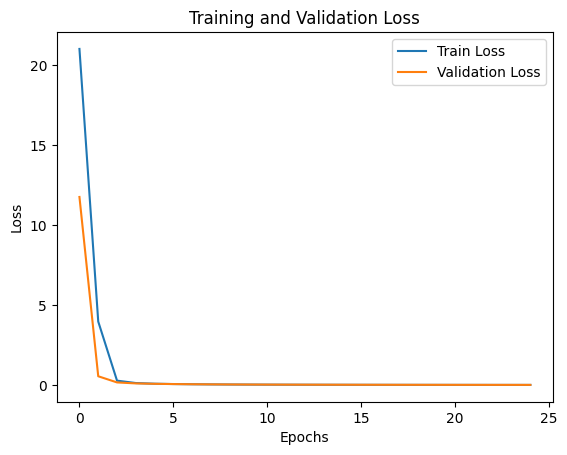

In [ ]:
test_loss = nnmodel.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")
# Make predictions
y_pred = nnmodel.predict(X_test)

# Calculate Mean Squared Error on predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Data: {mse}")

# Step 8: (Optional) Visualize Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Using dropout & early stopping

In [ ]:
dropout_model = Sequential()
dropout_model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
dropout_model.add(Dropout(0.2))  # Dropout with a rate of 0.2 (20% of neurons are dropped)
dropout_model.add(Dense(8, activation='relu'))
dropout_model.add(Dropout(0.2))
dropout_model.add(Dense(1))

dropout_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

history = dropout_model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 27.3409 - mse: 27.3409 - val_loss: 16.7534 - val_mse: 16.7534
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.4354 - mse: 12.4354 - val_loss: 1.7788 - val_mse: 1.7788
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4306 - mse: 3.4306 - val_loss: 0.4719 - val_mse: 0.4719
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6868 - mse: 2.6868 - val_loss: 0.2652 - val_mse: 0.2652
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3732 - mse: 2.3732 - val_loss: 0.2271 - val_mse: 0.2271
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3183 - mse: 2.3183 - val_loss: 0.2212 - val_mse: 0.2212
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1168 - mse: 2.1168 - val_loss: 0.1935 - val_mse: 0.1935
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0429 - mse: 2.0429 - val_loss: 0.1770 - val_mse: 0.1770
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

In [ ]:
# Evaluate the model on the test data
test_loss, test_mse = dropout_model.evaluate(X_test, y_test, verbose=0)

# Print results
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MSE: {test_mse}")

y_pred = dropout_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Data: {mse}")

Test Loss (MSE): 0.07745704054832458
Test MSE: 0.07745704054832458
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error on Test Data: 0.07745702691646134


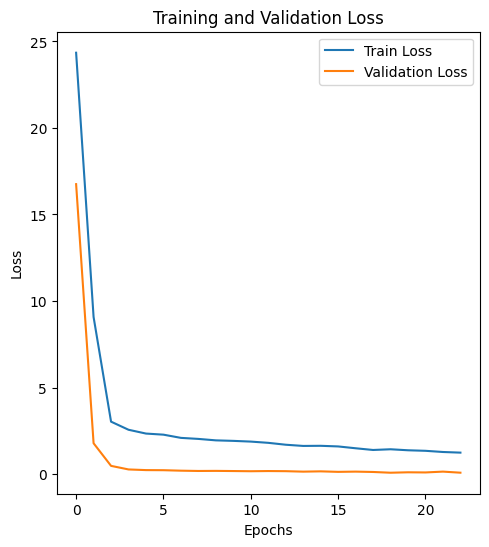

In [ ]:
# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()